# 유튜브 댓글을 통한 결혼 트렌드 조사

유튜브에서 '결혼'을 키워드로 검색한 후, 등장한 영상에 달린 댓글을 직접 크롤링하여 자연어 데이터를 분석한 결과입니다.

## 한글 처리를 위한 패키지, 데이터 불러오기

In [1]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

!apt-get update -qq
!apt-get install fonts-nanum* -qq

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 31 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")
        
current_font()

Python 3.7.14
설정 폰트 글꼴: ['NanumBarunGothic'], 설정 폰트 사이즈: 10.0


In [39]:
%matplotlib inline  

import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


In [40]:
import pandas as pd

df = pd.read_excel('유튜브_결혼_댓글_2022-07-01-13-12.xlsx')
df.shape

(1894, 3)

## 데이터 전처리

konlpy 패키지를 통해 한글 자연어 처리를 진행합니다.

In [41]:
df.isnull().sum()

id          1132
like        1308
comments    1126
dtype: int64

데이터가 없는 row는 모두 삭제하고, 유튜브 아이디와 좋아요 갯수의 결측치는 각각 빈칸이나 0처리 하였습니다.

In [44]:
df = df.dropna(how='all')

df['id'] = df['id'].fillna('')
df['like'] = df['like'].fillna(0).astype('int64')

df.isnull().sum()

id          0
like        0
comments    0
dtype: int64

konlpy의 여러 형태소 분석기 중, sns 분석에 가장 적합하다고 알려진 Okt를 활용하고 명사 단어만을 추출합니다.

In [46]:
import konlpy
from konlpy.tag import Okt
import re
okt = Okt()

dataset = []

for i in range(len(df)):
  dataset.append(okt.nouns(re.sub('[^가-힣a-zA-Z\s]','', df.iloc[i,2])))


In [13]:
dataset[:5]

[['스드메',
  '이제',
  '막',
  '준비',
  '진짜',
  '도움',
  '말씀',
  '것',
  '스튜디오',
  '메이크업',
  '드레스',
  '차이',
  '크게',
  '방황',
  '팁',
  '다음',
  '영상',
  '기대'],
 ['부분', '대해', '속', '집중'],
 ['진짜', '구체', '다담', '주', '너', '상담'],
 ['정보'],
 ['저',
  '식장',
  '관료',
  '홀',
  '패키지',
  '만원',
  '스드메',
  '평균',
  '선',
  '벨루',
  '마마',
  '만원',
  '패키지',
  '막']]

데이터 내 한글자 자연어는 중요도가 낮다는 판단 하에, 개인적으로 보유한 한글자 단어 파일을 활용해 삭제하고자 합니다. 아울러 sns 용어, 고유명사 등의 단어는 불용어처리 합니다.

In [45]:
one = pd.read_csv('한글자 단어.csv', header= None)

one_list = one[0].to_list()

In [47]:
stopWord = ['\n',',','는','이','0','도','뭐','제','생각','막','영상','이','모나','언니','트위티','스위티','설명','구독','정리','그리고','도움','혹시','저','부터','이제','진짜','것','처럼','다음','요','너','가요','정말','한번','은','를']

for k in range(len(dataset)):
  for j in dataset[k]:
    for i in stopWord:
      if i == j:
        try:
          dataset[k].remove(i)
        except:
          pass

for k in range(len(dataset)):
  for j in dataset[k]:
    for i in one_list:
      if i == j:
        try:
          dataset[k].remove(i)
        except:
          pass

dataset[:5]

[['스드메',
  '준비',
  '도움',
  '말씀',
  '스튜디오',
  '메이크업',
  '드레스',
  '차이',
  '크게',
  '방황',
  '영상',
  '기대'],
 ['부분', '대해', '집중'],
 ['구체', '다담', '상담'],
 ['정보'],
 ['식장', '관료', '패키지', '만원', '스드메', '평균', '벨루', '마마', '만원', '패키지']]

## 연관규칙분석(장바구니 분석) Apriori 알고리즘을 활용한 분석

일반적으로 연관규칙분석에서 가장 많이 사용하는 알고리즘은 Apriori와 FP-growth 으로 알려져 있습니다. 

본 분석은 데이터 갯수가 적고 간단한 원리(지지도 및 신뢰도)를 통한 분석이 알맞을 것이라 판단하여 Apriori 알고리즘을 활용합니다.

In [48]:
from mlxtend.preprocessing import TransactionEncoder as ts

te = ts()
te_ary = te.fit(dataset).transform(dataset)
data = pd.DataFrame(te_ary, columns=te.columns_)
data.head()

,가격,가계부,가계약,가구,가능,가도,가득,가랑비,가르마,가면,...,후기,후반,후원,후줄,후진,후회,흐름,힌,힐링,힘들엇네
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


최소 지지도를 설정하여, 이보다 높은 지지도를 가지는 단어들만 추출합니다.

In [50]:
from mlxtend.frequent_patterns import apriori
frequent_itemsets = apriori(data, min_support=0.02, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

frequent_itemsets

,support,itemsets,length
0,0.033854,(가격),1
1,0.333333,(결혼),1
2,0.105469,(결혼식),1
3,0.020833,(계약),1
4,0.020833,(고민),1
5,0.023438,(금액),1
6,0.022135,(년),1
7,0.028646,(다시),1
8,0.026042,(다인),1
9,0.029948,(달님),1


최소 지지도보다 높은 단어들 중, 두 쌍으로 이루어진(length == 2) 단어쌍만 추출합니다.

In [51]:
frequent_itemsets[(frequent_itemsets['length'] == 2)].sort_values(by='support', ascending=False)

,support,itemsets,length
50,0.128906,"(준비, 결혼)",2
51,0.054688,"(축하, 결혼)",2
49,0.046875,"(정보, 결혼)",2
47,0.041667,"(비용, 결혼)",2
44,0.035156,"(결혼식, 결혼)",2
46,0.024740,"(보고, 결혼)",2
53,0.024740,"(결혼식, 비용)",2
54,0.023438,"(결혼식, 준비)",2
45,0.022135,"(다시, 결혼)",2
55,0.022135,"(준비, 정보)",2


최종적인 결과를 향상도 기준으로 나열하면 다음과 같습니다. 

일반적으로 향상도가 1보다 크면, 양의 상관관계를 가지고 있다고 정의할 수 있습니다. 

따라서 아래의 결과는 두 단어간의 관계가 유의미함을 나타냅니다.

In [55]:
from mlxtend.frequent_patterns import association_rules
association_rules(frequent_itemsets, metric='confidence', min_threshold=0).sort_values(by='lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
19,(비용),(결혼식),0.072917,0.105469,0.024740,0.339286,3.216931,0.017049,1.353885
18,(결혼식),(비용),0.105469,0.072917,0.024740,0.234568,3.216931,0.017049,1.211190
2,(다시),(결혼),0.028646,0.333333,0.022135,0.772727,2.318182,0.012587,2.933333
3,(결혼),(다시),0.333333,0.028646,0.022135,0.066406,2.318182,0.012587,1.040446
12,(준비),(결혼),0.170573,0.333333,0.128906,0.755725,2.267176,0.072049,2.729167
13,(결혼),(준비),0.333333,0.170573,0.128906,0.386719,2.267176,0.072049,1.352442
14,(축하),(결혼),0.076823,0.333333,0.054688,0.711864,2.135593,0.029080,2.313725
15,(결혼),(축하),0.333333,0.076823,0.054688,0.164062,2.135593,0.029080,1.104361
6,(비용),(결혼),0.072917,0.333333,0.041667,0.571429,1.714286,0.017361,1.555556
7,(결혼),(비용),0.333333,0.072917,0.041667,0.125000,1.714286,0.017361,1.059524


## networkx를 활용한 네트워크 시각화

위에서 도출한 결과를 시각화하기 위해, networkx 패키지를 활용하였습니다.

노드 간의 연결 관계를 나타내기 위한 척도로는 지지도를 사용하였습니다.

In [67]:
from mlxtend.frequent_patterns import apriori
result = apriori(data, min_support=0.02, use_colnames=True)
df = pd.DataFrame(result)
df['length'] = df['itemsets'].apply(lambda x: len(x))
df = df[(df['length'] == 2) & (df['support'] >= 0.01)].sort_values(by='support', ascending=False)
df.head()

,support,itemsets,length
50,0.128906,"(준비, 결혼)",2
51,0.054688,"(축하, 결혼)",2
49,0.046875,"(정보, 결혼)",2
47,0.041667,"(비용, 결혼)",2
44,0.035156,"(결혼식, 결혼)",2


위의 데이터를 기반으로 네트워크를 구성합니다.

In [69]:
import networkx as nx

g = nx.Graph()
ar = df['itemsets']
g.add_edges_from(ar)

노드의 색깔 명암과 크기를 지지도에 따라 구성하였습니다.

In [70]:
import numpy as np
pr = nx.pagerank(g)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize - min(nsize)) / (max(nsize) - min(nsize))

네트워크를 최종적으로 시각화한 결과물입니다.

결혼 키워드를 중심으로, 위쪽의 '비용', '결혼식', '정보' 등에 대한 관심도가 가장 큰 것을 알 수 있습니다.

또한, '결혼식' 키워드를 중심으로 '비용'과 '준비' 키워드가 연결되어 있는것을 알 수 있습니다. 이는 많은 소비자들이 결혼식과 비용, 준비를 연관지어 생각한다는 점을 시사합니다.

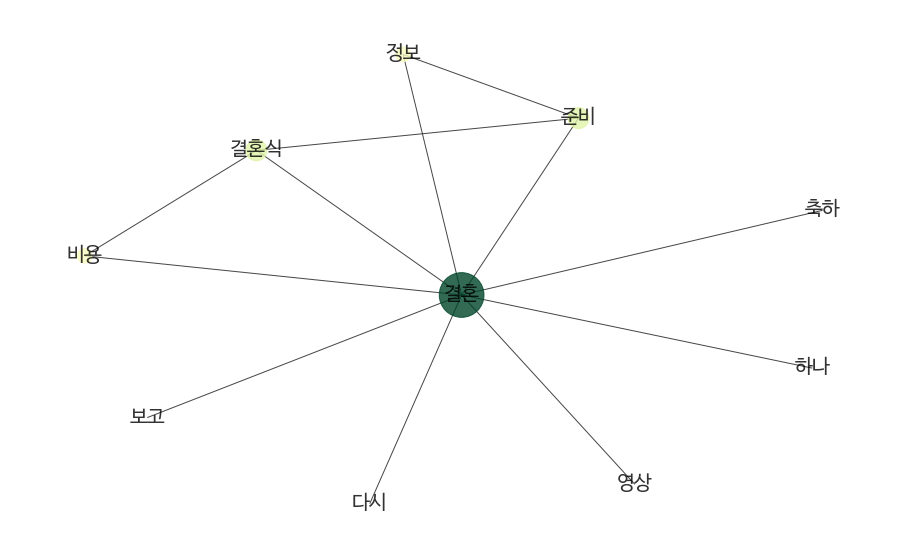

In [71]:
plt.figure(figsize = (16,10))
plt.axis('off')
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx(g, font_size=20, pos=pos, node_color=list(pr.values()), font_family = font_name, alpha=0.8, edge_color='.1', cmap=plt.cm.YlGn, node_size = nsize)